In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from re import sub
from decimal import Decimal

import tensorflow as tf
from tensorflow import keras

## Cleaning the Data

In [45]:
players = pd.read_csv('data/player_data.csv', header=0)
contracts = pd.read_csv('data/contracts.csv', header=0)

In [46]:
players = players[(players['Lg'] == 'NBA') & (players['Season'] == '2021-22')]
players['Player'] = players['Player'].str.replace('\n', '')
players = players[['Player', 'Season', 'Age', 'Tm', 'Lg', 'Pos', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']]

In [47]:
# get list of all duplicate players
duplicates_tot = players[players['Tm'] == 'TOT']

duplicates_names = duplicates_tot['Player'].unique().tolist()

last_team_dict = {}

for name in duplicates_names:
    # get last time player played
    last_team_dict[name] = players[players['Player'] == name]['Tm'].unique()[-1]

duplicates_tot = duplicates_tot[duplicates_tot['Tm'] == 'TOT']

# set all duplicate players to last team played
duplicates_tot['Tm'] = duplicates_tot['Player'].map(last_team_dict)

# delete all players where name is in duplicates_names
players = players[~players['Player'].isin(duplicates_names)]

# add duplicates to players
players = pd.concat([players, duplicates_tot])

# if pos has multiple values, take the first comma separated value
players['Pos'] = players['Pos'].str.split(',').str[0]

In [48]:
players[players['Player'] == 'James Harden']

,Player,Season,Age,Tm,Lg,Pos,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
51,James Harden,2021-22,32,PHI,NBA,PG,65,2419,407,992,...,0.877,55,445,500,667,82,36,284,153,1432


In [49]:
contracts = contracts[['Player', 'Tm', '2021-22']]

# Convert salary to a float
contracts['2021-22'] = contracts['2021-22'].apply(lambda x: sub(r'[^\d.]', '', str(x)))

# Remove empty salaries
contracts = contracts[contracts['2021-22'] != '']

# Convert salary to a float
contracts['2021-22'] = contracts['2021-22'].astype(float)

# Combine players and contracts
players = pd.merge(players, contracts, on=['Player', 'Tm'], how='left')

# Remove all rows with NaN values
players = players.dropna()

contracts[contracts['Player'] == 'James Harden']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Player,Tm,2021-22
3,James Harden,PHI,43848000.0


In [50]:
players[players['Player'] == 'James Harden']

,Player,Season,Age,Tm,Lg,Pos,GS,MP,FG,FGA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,2021-22
503,James Harden,2021-22,32,PHI,NBA,PG,65,2419,407,992,...,55,445,500,667,82,36,284,153,1432,43848000.0


## Observing the Data

In [51]:
numeric_data = players.select_dtypes(include=[np.number])

Correlation matrix:

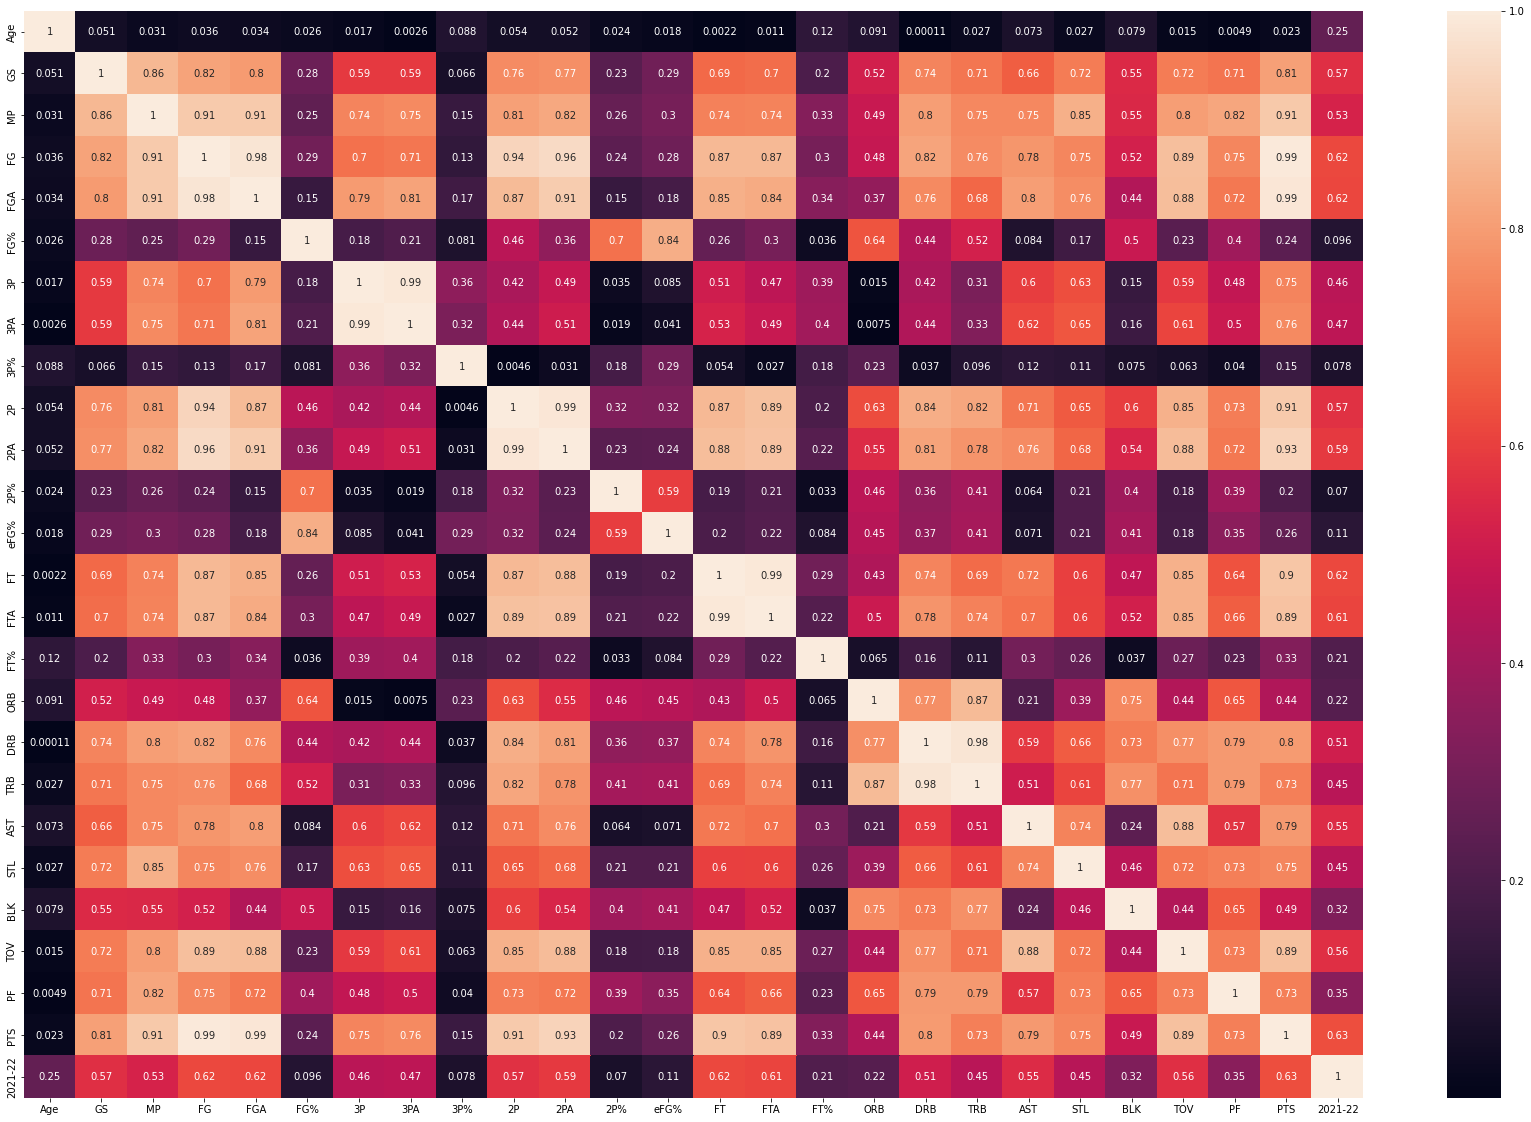

In [52]:
plt.figure(figsize=(30, 20))
sns.heatmap(numeric_data.corr().abs(), annot=True)

**Result:** Salary seems to be decently correlated with FG, FGA, FT, FTA, and PTS. There is also OK correlation between salary and AST, TOV, 2P, 2PA, GS, and MP.

All of this makes sense so far and is what I expected.

## Normalization & Train/Test Data

In [64]:
model_keys = ['FG', 'FGA', 'FT', 'FTA', 'PTS', 'AST', 'TOV', '2P', '2PA', 'GS', 'MP']

ct = make_column_transformer(
    (MinMaxScaler(), model_keys)
)

In [65]:
# Features
X = players.drop("2021-22", axis=1)

# Labels
y = players["2021-22"]

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=66)

In [67]:
ct.fit(X_train)

X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

## Neural Network

In [68]:
tf.random.set_seed(66)

nba_model = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1)
])

nba_model.compile(loss=tf.keras.losses.mae,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                  metrics=["mae"])

fit_data = nba_model.fit(X_train_normal, y_train, epochs=100, verbose=0)

In [69]:
nba_model_loss, nba_model_mae = nba_model.evaluate(X_test_normal, y_test)

5/5 [==============================] - 0s 3ms/step - loss: 3925125.7500 - mae: 3925125.7500


In [70]:
nba_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 100)               1200      
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 21,501
Trainable params: 21,501
Non-trainable params: 0
_________________________________________________________________


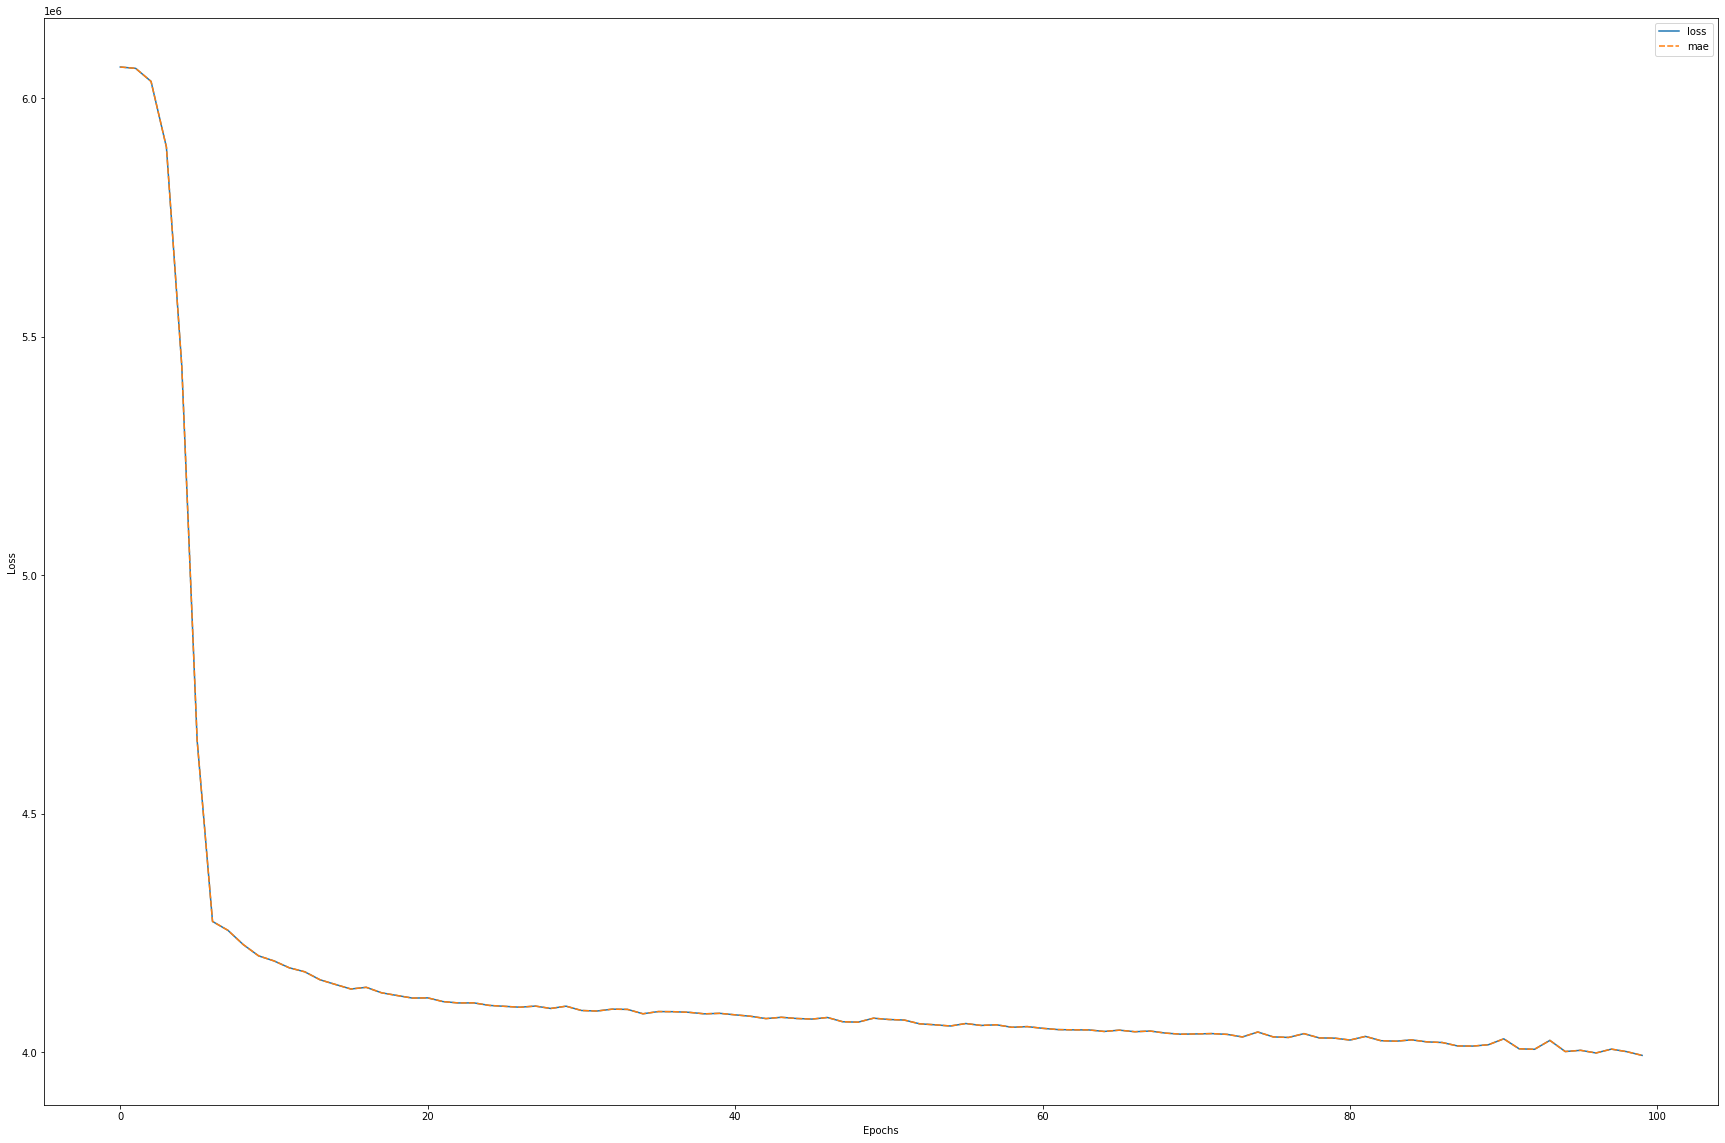

In [71]:
plt.figure(figsize=(30,20))
plt.ylabel("Loss")
plt.xlabel("Epochs")
sns.lineplot(data=fit_data.history)